This is a simple example show-casing how to set up a simple audio decoder pipeline.

We load and decode audio data using rocAL.

The input data we will be using to show-case this example is a speech dataset which is present in the form of wav files.

We will start by importing rocAL and other necessary packages which is show in the cell below

In [86]:
!pip install opencv-python
!pip install matplotlib


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [87]:
import random
import numpy as np
from amd.rocal.plugin.pytorch import ROCALAudioIterator
import torch
np.set_printoptions(threshold=1000, edgeitems=10000)
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types
import math
import sys
import cv2
import matplotlib.pyplot as plt
import os

In [88]:
def draw_patches(img, idx, device):
    image = img.detach().numpy()
    audio_data = image.flatten()
    label = idx.cpu().detach().numpy()
    print("label: ", label)
    plt.plot(audio_data)
    plt.show()
    plt.close()

In [89]:
# NOTE: Set the ROCAL_DATA_PATH env variable before running the botebook

# Check if ROCAL_DATA_PATH is set
rocal_data_path = os.environ.get('ROCAL_DATA_PATH')

if rocal_data_path is None:
    print("The environment variable ROCAL_DATA_PATH is not set.")
else:
    print(f"ROCAL_DATA_PATH is set to: {rocal_data_path}")

rocal_audio_data_path = os.path.join(rocal_data_path, "rocal_data", "audio")


ROCAL_DATA_PATH is set to: /media/Jupyter_NB/source_folder/MIVisionX-data/


rocAL Pipeline configration with the batch_size, num_threads and weather cpu / gpu backend is used

In [90]:
file_list = f"{rocal_audio_data_path}/wav_file_list.txt" #Use file list defined in the MIVisisonX-data repo
rocal_cpu = True
audio_pipeline = Pipeline(batch_size=1, num_threads=8, rocal_cpu=rocal_cpu)

Pipeline has been created succesfully
OK: loaded 125 kernels from libvx_rpp.so


Defining the Audio Decoder Pipeline with downmix as False

In [91]:
with audio_pipeline:
    audio, labels = fn.readers.file(file_root=rocal_audio_data_path, file_list=file_list)
    decoded_audio = fn.decoders.audio(
        audio,
        file_root=rocal_audio_data_path,
        file_list_path=file_list,
        downmix=False,
        shard_id=0,
        num_shards=1,
        stick_to_shard=True)
    audio_pipeline.set_outputs(decoded_audio)


pad_last_batch_repeated in decoders.py ::  False



 inside rocal_api_data_loader.cpp
 #ifdef ROCAL_AUDIO - inside rocal_api_data_loader.cpp

In [92]:
audio_pipeline.build()
audioIterator = ROCALAudioIterator(audio_pipeline)

The output from the iterator contains the audio data as torch tensors, the label of the corresponding data and region of intrest.

Audio shape:  torch.Size([31440, 1])
Label:  tensor(0)
Roi:  tensor([31440,     1], dtype=torch.int32)
label:  0


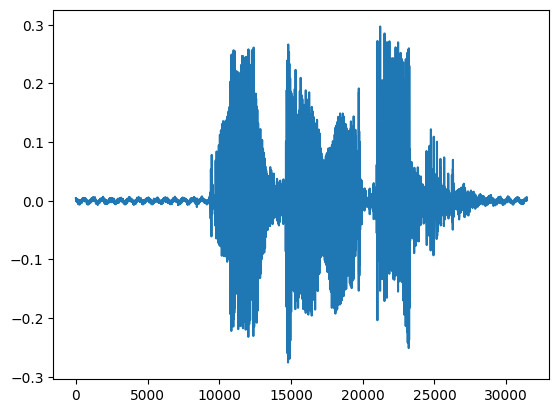

Audio shape:  torch.Size([240400, 1])
Label:  tensor(1)
Roi:  tensor([240400,      1], dtype=torch.int32)
label:  1


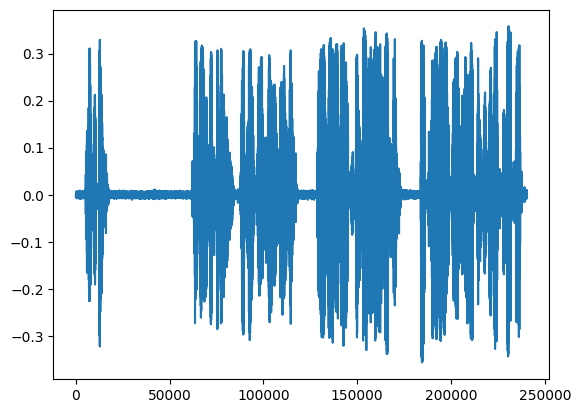

Audio shape:  torch.Size([253040, 1])
Label:  tensor(2)
Roi:  tensor([253040,      1], dtype=torch.int32)
label:  2


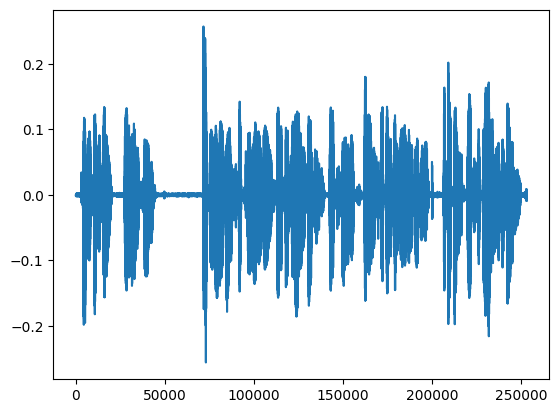

Audio shape:  torch.Size([210320, 1])
Label:  tensor(3)
Roi:  tensor([210320,      1], dtype=torch.int32)
label:  3


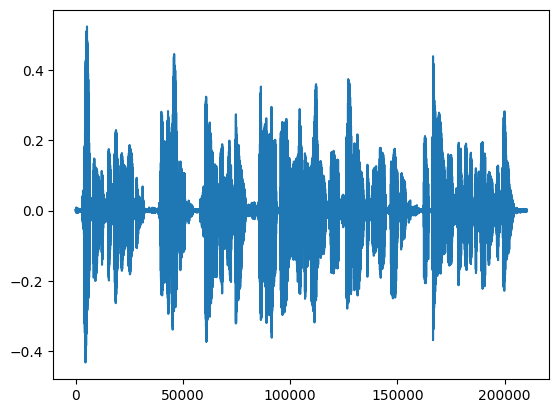

Audio shape:  torch.Size([34160, 1])
Label:  tensor(4)
Roi:  tensor([34160,     1], dtype=torch.int32)
label:  4


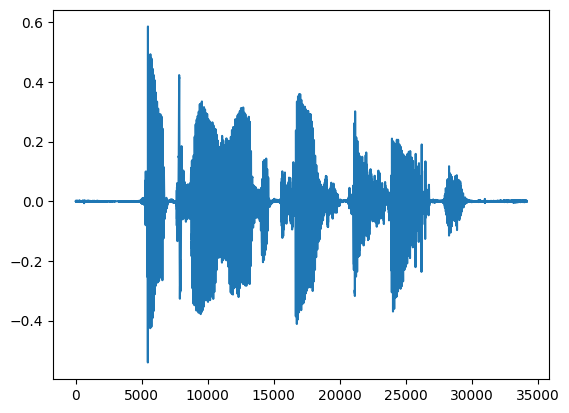

Audio shape:  torch.Size([188240, 1])
Label:  tensor(5)
Roi:  tensor([188240,      1], dtype=torch.int32)
label:  5


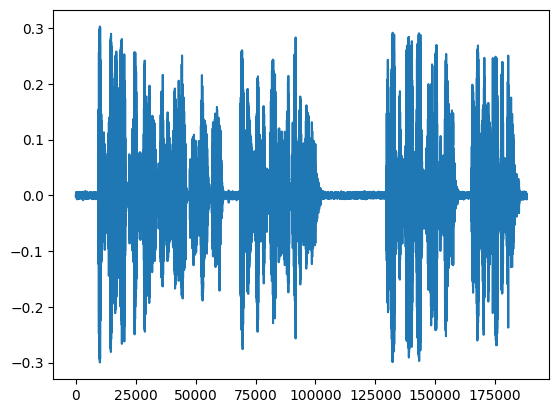

Audio shape:  torch.Size([255840, 1])
Label:  tensor(6)
Roi:  tensor([255840,      1], dtype=torch.int32)
label:  6


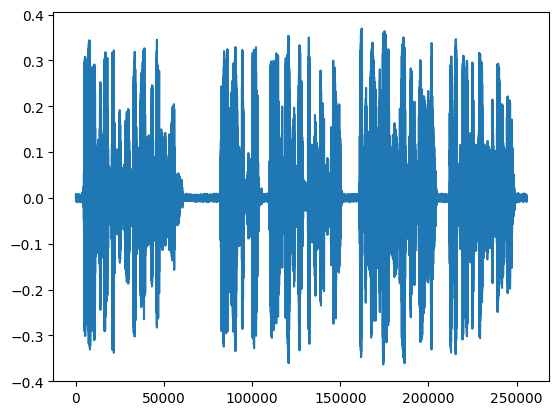

Audio shape:  torch.Size([254720, 1])
Label:  tensor(7)
Roi:  tensor([254720,      1], dtype=torch.int32)
label:  7


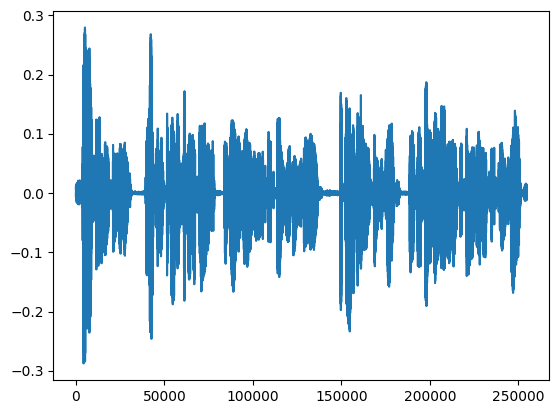

Audio shape:  torch.Size([234080, 1])
Label:  tensor(8)
Roi:  tensor([234080,      1], dtype=torch.int32)
label:  8


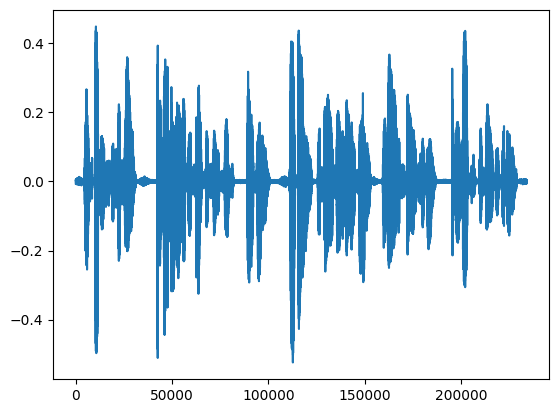

Audio shape:  torch.Size([37200, 1])
Label:  tensor(9)
Roi:  tensor([37200,     1], dtype=torch.int32)
label:  9


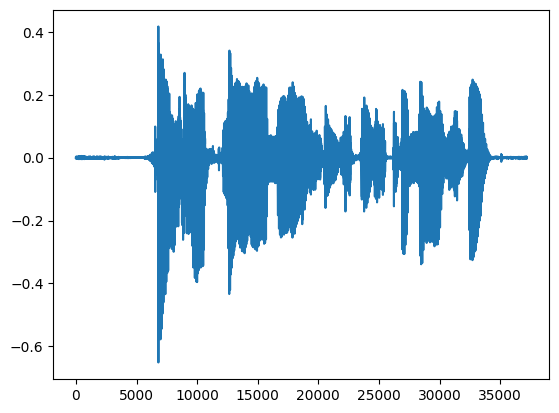

In [93]:
for i, output_list in enumerate(audioIterator):
    for x in range(len(output_list[0])):
        for audio_tensor, label, roi in zip(output_list[0][x], output_list[1], output_list[2]):
            print("Audio shape: ", audio_tensor.shape)
            print("Label: ", label)
            print("Roi: ", roi)
            draw_patches(audio_tensor, label, "cpu")
audioIterator.reset()